In [31]:
!pip install textblob

  Using cached textblob-0.17.1-py2.py3-none-any.whl (636 kB)


In [51]:
!pip install spacy

  Using cached pydantic-1.8.2-cp38-cp38-win_amd64.whl (2.0 MB)


In [37]:
!pip install STOPWORDS

In [35]:
!pip install wordcloud

In [47]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

import tweepy
import csv
import os
import pandas as pd

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# !pip3 install -U spacy
# !python3 -m spacy download en_core_web_sm

from sklearn.metrics import jaccard_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
# %load extract_dataframe.py
import pandas as pd
import json
from textblob import TextBlob


class ExtractTweets:
    """
    - class for extracting tweets
    """
    def __init__(self,json_file: str)->list:
        data = []
        for tweets in open(json_file,'r'):
            data.append(json.loads(tweets))
        self.tweets = data

    def get_tweets(self):
        """just a basic function of getting tweets"""
        return self.tweets

    def find_statuses_count(self)->list:
        """
        - this function returns the status counts
        """
        return list(map(lambda tweet: tweet['user']['statuses_count'], self.tweets))
    
    def find_full_text(self)->list:
        """
        - this function extracts the full texts of
        the tweets
        """
        return list(map(lambda tweet: tweet['text'], self.tweets))
        

    def find_sentiments(self, data:list)->list:
        """
        - this function finds sentiments from the dataset
        """
        get_polarity = [TextBlob(text).sentiment.polarity for text in data]
        get_subjectivity = [TextBlob(text).sentiment.subjectivity for text in data]
        return get_polarity, get_subjectivity

    def find_created_time(self)->list:
        """
        - this function returns a list of 
        the created time tags for when the tweet was generated
        """
        return  list(map(lambda tweet: tweet['created_at'], self.tweets))


    def find_source(self)->list:
        """
        - this function returns the source of the tweet
        """
        return  list(map(lambda tweet: tweet['source'], self.tweets))
        
    def find_screen_name(self)->list:
        """
        - this function returns the screen name of the person who has tweeted
        """
        return  list(map(lambda tweet: tweet['user']['screen_name'], self.tweets))
        
    def find_followers_count(self)->list:
        """
        - this function returns the amount of followers per user
        """
        return  list(map(lambda tweet: tweet['user']['followers_count'], self.tweets))
        
    def find_friends_count(self)->list:
        """
        - this function returns the number of friends the user has
        """
        return  list(map(lambda tweet: tweet['user']['friends_count'], self.tweets))
        
    def is_sensitive(self)->list:
        """
        - this function checks whether the data is sensitive or not
        """
        return [tweet['possibly_sensitive'] if "possibly_sensitive" in tweet.keys() else None \
        for tweet in self.tweets]
               

    def find_favourite_count(self)->list:
        """
        - this function returns the amount of times the tweet has been counted
        as favorite
        """
        return [tweet['retweeted_status']['favorite_count'] if 'retweeted_status' in tweet.keys() else 0 \
        for tweet in self.tweets]
        
    def find_retweet_count(self)->list:
        """
        - this function finds how many times a tweet has been retweeted
        """
        return [tweet['retweeted_status']['retweet_count'] if 'retweeted_status' in tweet.keys() else 0 \
        for tweet in self.tweets]
        
    
    def find_hashtags(self) -> list:
        """
        return the amount of hashtags in tweets
        """
        return [tweet.get('entities',dict()).get('hashtags', None)
                    for tweet in self.tweets]

        
    def find_mentions(self)->list:
        """
        - this function returns how many times 
        a person was mentioned in a tweet
        """
        return [" , ".join([count_['screen_name']  for tweet in self.tweets for count_ in tweet['entities']['user_mentions']])]
    
    def find_lang(self)->list:
        """
        return the language used to tweet
        """
        return list(map(lambda tweet:tweet['lang'],self.tweets))

    def find_location(self)->list:
        """
        returns the location in which the tweet was published
        """
        return [tweet['user']['location'] for tweet in self.tweets]
        
    def get_tweet_df(self, save=False)->pd.DataFrame:
        """required column to be generated you should be creative and add more features"""
        
        columns = ['created_at', 'source', 'original_text','polarity','subjectivity', 'lang', 'favorite_count', 'retweet_count', 
            'original_author', 'followers_count','friends_count','possibly_sensitive', 'hashtags', 'user_mentions', 'place']
        
        created_at = self.find_created_time()
        source = self.find_source()
        text = self.find_full_text()
        polarity, subjectivity = self.find_sentiments(text)
        lang = self.find_lang()
        fav_count = self.find_favourite_count()
        retweet_count = self.find_retweet_count()
        screen_name = self.find_screen_name()
        follower_count = self.find_followers_count()
        friends_count = self.find_friends_count()
        sensitivity = self.is_sensitive()
        hashtags = self.find_hashtags()
        mentions = self.find_mentions()
        location = self.find_location()
        values = [created_at, source, text, polarity, subjectivity, lang, fav_count, retweet_count, screen_name, follower_count, friends_count, sensitivity, hashtags, mentions, location]
        data_ = dict(zip(columns,values))
        data  = { key:pd.Series(value) for key, value in data_.items() }
        df = pd.DataFrame(data=data)
        
        if save:
            df.to_csv('data/processed_tweet_data.csv', index=False)
            print('File Successfully Saved.!!!')
            
        return df


if __name__ == "__main__":

    extracted_tweets = ExtractTweets("data/Economic_Twitter_Data.json")
    df = extracted_tweets.get_tweet_df(save=True)
    

File Successfully Saved.!!!


In [83]:
import pandas as pd
df = pd.read_csv('df.csv')
df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.54,en,188,43,davideiacovozzi,18,55,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",NaN,NaN,NaN,NaN,NaN
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175,en,179,32,davideiacovozzi,18,55,NaN,[],NaN,NaN,NaN,NaN,NaN
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0,0,en,193,26,davideiacovozzi,18,55,FALSE,[],NaN,NaN,NaN,NaN,NaN
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0,0.183333333,en,620,213,davideiacovozzi,18,55,NaN,[],NaN,NaN,NaN,NaN,NaN
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.4,0.4,en,1787,417,davideiacovozzi,18,55,FALSE,[],NaN,NaN,NaN,NaN,NaN


In [85]:
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_at          23234 non-null  object
 1   source              20213 non-null  object
 2   original_text       20070 non-null  object
 3   polarity            15257 non-null  object
 4   subjectivity        15255 non-null  object
 5   lang                15195 non-null  object
 6   favorite_count      15180 non-null  object
 7   retweet_count       15180 non-null  object
 8   original_author     15180 non-null  object
 9   followers_count     13012 non-null  object
 10  friends_count       14906 non-null  object
 11  possibly_sensitive  4230 non-null   object
 12  hashtags            13262 non-null  object
 13  user_mentions       307 non-null    object
 14  place               7065 non-null   object
 15  Unnamed: 15         25 non-null     object
 16  Unnamed: 16         2 

In [103]:
data=df.drop(['Unnamed: 16', 'Unnamed: 17', 'Unnamed: 15' ], axis = 1)
data

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.54,en,188,43,davideiacovozzi,18,55,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",NaN,NaN
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175,en,179,32,davideiacovozzi,18,55,NaN,[],NaN,NaN
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0,0,en,193,26,davideiacovozzi,18,55,FALSE,[],NaN,NaN
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0,0.183333333,en,620,213,davideiacovozzi,18,55,NaN,[],NaN,NaN
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.4,0.4,en,1787,417,davideiacovozzi,18,55,FALSE,[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27095,2022-04-22 15:22:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85,1,en,14671,5006,kitukalesatya,706,643,NaN,[],NaN,NaN
27096,2022-04-22 15:01:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...,0,0,en,5056,973,kitukalesatya,706,643,FALSE,[],NaN,NaN
27097,2022-04-22 14:58:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...,-0.3,0.6,en,636,115,kitukalesatya,706,643,FALSE,[],NaN,NaN
27098,2022-04-22 14:44:35+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @Parthtiwari25: Gujarat Congress MLA arrest...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   created_at          23234 non-null  object
 1   source              20213 non-null  object
 2   original_text       20070 non-null  object
 3   polarity            15257 non-null  object
 4   subjectivity        15255 non-null  object
 5   lang                15195 non-null  object
 6   favorite_count      15180 non-null  object
 7   retweet_count       15180 non-null  object
 8   original_author     15180 non-null  object
 9   followers_count     13012 non-null  object
 10  friends_count       14906 non-null  object
 11  possibly_sensitive  4230 non-null   object
 12  hashtags            13262 non-null  object
 13  user_mentions       307 non-null    object
 14  place               7065 non-null   object
dtypes: object(15)
memory usage: 3.1+ MB


<AxesSubplot:title={'center':'The 10 Most Frequent Used Languages In Tweets'}, xlabel='Languages', ylabel='Frequency'>

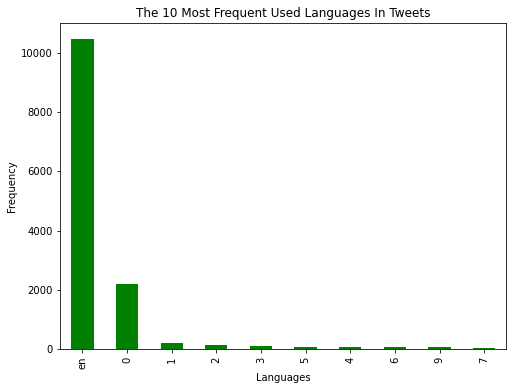

In [96]:
fig,ax = plt.subplots()
ax.tick_params(axis='x',labelsize=10)
ax.tick_params(axis='y',labelsize=10)
ax.set_xlabel("Languages")
ax.set_ylabel("Frequency")
ax.set_title("The 10 Most Frequent Used Languages In Tweets")
tweets_according_language[:10].plot(ax=ax,kind='bar',color='green')


In [112]:
missing_values = data.isnull().sum().sum()
missing_values

198954

In [117]:
df2=data.dropna(subset=['polarity'])
df2['polarity'].unique()

array(['0.16', '0.15', '0', '-0.4', '-0.1', 'en', '0.25', '0.175', '0.5',
       '0.285555556', '0.591666667', '1', '-0.45', '-0.072222222',
       '-0.0375', '-0.066666667', '-0.077777778', '-0.5', '0.875',
       '0.357142857', '-0.6', '0.06', '-0.3', '-0.163690476', '-0.625',
       '0.418181818', '0.142857143', '0.102777778', '0.4', '-0.35',
       '0.155555556', '-0.15', '0.6', '0.2', '-0.05', '0.011111111',
       '0.133333333', '-0.25', '-0.0625', '0.266666667', '0.05', '-0.025',
       '-0.233333333', '0.216666667', '0.383333333', '0.285714286',
       '0.083333333', '0.053333333', '0.009375',
       ' ice pellets and even thunderstorms are in the…"', '0.1', '0.075',
       '0.225', '-0.075', '0.068181818', '0.35', '0.166666667', '0.45',
       ' justifying and excusing ableism."', '-0.133333333', '-0.3125',
       '-0.2', '-0.155555556', '0.8', '-0.8', '-0.291666667',
       ' Shop items and much mo…"', '0.316666667', '-0.125',
       '-0.083333333', '0.75', '0.220238095', '-0

In [100]:
df['polarity'].unique()

array(['0.16', '0.15', '0', '-0.4', '-0.1', nan, 'en', '0.25', '0.175',
       '0.5', '0.285555556', '0.591666667', '1', '-0.45', '-0.072222222',
       '-0.0375', '-0.066666667', '-0.077777778', '-0.5', '0.875',
       '0.357142857', '-0.6', '0.06', '-0.3', '-0.163690476', '-0.625',
       '0.418181818', '0.142857143', '0.102777778', '0.4', '-0.35',
       '0.155555556', '-0.15', '0.6', '0.2', '-0.05', '0.011111111',
       '0.133333333', '-0.25', '-0.0625', '0.266666667', '0.05', '-0.025',
       '-0.233333333', '0.216666667', '0.383333333', '0.285714286',
       '0.083333333', '0.053333333', '0.009375',
       ' ice pellets and even thunderstorms are in the…"', '0.1', '0.075',
       '0.225', '-0.075', '0.068181818', '0.35', '0.166666667', '0.45',
       ' justifying and excusing ableism."', '-0.133333333', '-0.3125',
       '-0.2', '-0.155555556', '0.8', '-0.8', '-0.291666667',
       ' Shop items and much mo…"', '0.316666667', '-0.125',
       '-0.083333333', '0.75', '0.220238095'

In [165]:
list1 =['located a…"', 'en', 'ice pellets and even thunderstorms are in the…"',' BT4 1PD',
       ' BT4 3BE',' Stock Market &amp; Web 3."', ' due to weather anomalies; w…"',' BT5 5HG', ' BT6 9FH', ' BT32 4ET', ' BT26 6JA',
       ' Down', ' and the time was so…"',' BT14 7EE','his name w…"', ' BT23 7DX', ' Antrim', ' BT37 0LE',
       ' BT11 9AP', ' BT39 9AG', ' BT36 5DB', ' BT3 9JL', ' BT8 8HS',
       ' BT27 4DR', ' BT78 1QZ', ' BT35 6PW', ' justifying and excusing ableism."', ' Shop items and much mo…"', ' etc.',  '… https://t.co/cHD8bA8ZhX"',  ' a… https://t.co/EfLCczgDb4"', ' affor… https://t.co/MyNgvqF2od"',  ' Mozilla',' Former AICC Secretary…"', ' amazing community of #MARVINAUTS', ' Sayema and 68 others"', '… https://t.co/zRYhehnlZE"', ' #NewIndia’…"',  ' as he takes you on an enlighten… https://t.co/WXkwEgqVbj"',
       ' as he takes you on an enligh… https://t.co/40lJ9MvbxZ"',' there will be lot of pres…"', ' good memories and hearts full of…"',  ' and having a laid-back good time —… https://t.co/8osQoLzmz7"', ' #NewInd…"',  '… https://t.co/OoKhqsPZ1b"',  ' &amp; in respect of the will of the pe…"',' our…"',' Dubli… https://t.co/PCdKci3dNF"', ' Louth', ' A91 F2VX',
       ' BT35 8DA', ' BT34 1JZ', ' BT34 1QA', ' BT32 4LF',  ' #Kenya ',' A/L', ' where they were spotte…"',' images &amp; comments on #LinkedIn. It helped us uncove…"',' afte… https://t.co/l4KVZwRlYd"']

In [179]:
print(df2[df2.polarity.isin(list1) == False])
df2

                      created_at  \
0      2022-04-22 22:17:05+00:00   
1      2022-04-22 13:44:53+00:00   
2      2022-04-22 06:10:34+00:00   
3      2022-04-21 17:22:09+00:00   
4      2022-04-21 10:32:26+00:00   
...                          ...   
27093  2022-04-22 21:32:18+00:00   
27094  2022-04-22 21:31:18+00:00   
27095  2022-04-22 15:22:29+00:00   
27096  2022-04-22 15:01:27+00:00   
27097  2022-04-22 14:58:12+00:00   

                                                  source  \
0      <a href="http://twitter.com/download/android" ...   
1      <a href="http://twitter.com/download/android" ...   
2      <a href="http://twitter.com/download/android" ...   
3      <a href="http://twitter.com/download/android" ...   
4      <a href="http://twitter.com/download/android" ...   
...                                                  ...   
27093  <a href="http://twitter.com/download/android" ...   
27094  <a href="http://twitter.com/download/android" ...   
27095  <a href="http://twit

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,2022-04-22 22:17:05+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @NorthstarCharts: The 10-year yield is tell...,0.16,0.54,en,188,43,davideiacovozzi,18,55,NaN,"[{'text': 'gold', 'indices': [116, 121]}, {'te...",NaN,NaN
1,2022-04-22 13:44:53+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @MichaelAArouet: German 10y mortgage rate w...,0.15,0.175,en,179,32,davideiacovozzi,18,55,NaN,[],NaN,NaN
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0,0,en,193,26,davideiacovozzi,18,55,FALSE,[],NaN,NaN
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0,0.183333333,en,620,213,davideiacovozzi,18,55,NaN,[],NaN,NaN
4,2022-04-21 10:32:26+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @biancoresearch: Rates rise until something...,-0.4,0.4,en,1787,417,davideiacovozzi,18,55,FALSE,[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27094,2022-04-22 21:31:18+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @Salt_Project_OS: Free yourself from writin...,0.4,0.8,en,46,3,RosieG1029,148,1240,NaN,[],NaN,NaN
27095,2022-04-22 15:22:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85,1,en,14671,5006,kitukalesatya,706,643,NaN,[],NaN,NaN
27096,2022-04-22 15:01:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...,0,0,en,5056,973,kitukalesatya,706,643,FALSE,[],NaN,NaN
27097,2022-04-22 14:58:12+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...,-0.3,0.6,en,636,115,kitukalesatya,706,643,FALSE,[],NaN,NaN


In [136]:
print(df2.drop(df2[df2.polarity.str.contains(r'[@#&$%/*]')
                 | df2.polarity.str.contains(r'[^a-zA-Z]')].index))

                                              created_at       source  \
10                             Until they can’t handle…"          0.4   
14     We should raise rates 8 to 9 more times and se...   0.48828125   
17      Demand is softening even before the Fed really…"         0.45   
21                Mind the gap! https://t.co/rz4T4qTWKV"  0.336607143   
24     The Japanification thesis actually suggests th...            0   
...                                                  ...          ...   
27074                                            • 12%…"  0.214285714   
27079           She didn't receive any email informing…"            0   
27088                                               #P…"            0   
27092       Infographic 42122-6 https://t.co/bgXzf0mq7A"            0   
27099  Gujarat Congress leader who's not even an MLA ...            0   

      original_text polarity subjectivity lang   favorite_count retweet_count  \
10           0.6375       en          802 

In [176]:
df2.polarity

0        0.16
1        0.15
2           0
3           0
4        -0.4
         ... 
27094     0.4
27095    0.85
27096       0
27097    -0.3
27099      en
Name: polarity, Length: 15257, dtype: object

In [95]:
tweets_df = pd.DataFrame(columns = ['original_text','lang'])
tweets_df['text'] = df['original_text'].to_list()
tweets_df['lang'] = df['lang'].to_list()
tweets_according_language = tweets_df['lang'].value_counts()



In [180]:
df[df['polarity'].apply(lambda x: str(x).isdigit())]

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,Unnamed: 15,Unnamed: 16,Unnamed: 17
2,2022-04-22 06:10:34+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @goldseek: When? https://t.co/kO2FfHKaZg,0,0,en,193,26,davideiacovozzi,18,55,FALSE,[],NaN,NaN,NaN,NaN,NaN
3,2022-04-21 17:22:09+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @charliebilello: The 30-year mortgage rate ...,0,0.183333333,en,620,213,davideiacovozzi,18,55,NaN,[],NaN,NaN,NaN,NaN,NaN
11,2022-04-18 09:31:42+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @BotBenFranklin: The horse thinks one thing...,0,0,en,18,4,davideiacovozzi,18,55,NaN,[],NaN,NaN,NaN,NaN,NaN
45,The post-WWII pickup seems rather a one-off ep...,"while long-term productivity tre…""",0,0,en,370,66,davideiacovozzi,18,55,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN
46,2022-04-09 10:31:14+00:00,"<a href=""http://twitter.com/download/android"" ...","""There are only nine meals between mankind and...",0,1,en,0,0,davideiacovozzi,18,55,FALSE,"[{'text': 'AlfredHenryLewis', 'indices': [58, ...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27076,2022-04-22 11:19:36+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @kparveen2005: Pray for his bail,0,0,en,178,39,ibrahimpatel007,4684,1225,NaN,[],NaN,"Hyderabad, India",NaN,NaN,NaN
27077,2022-04-22 11:19:33+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @LiveLawIndia: PIL filed in Supreme Court s...,0,0,en,551,144,ibrahimpatel007,4684,1225,NaN,"[{'text': 'Halal', 'indices': [115, 121]}]",NaN,"Hyderabad, India",NaN,NaN,NaN
27089,2022-04-22 21:38:48+00:00,"<a href=""http://twitter.com/download/android"" ...","RT @SSoccsksargen: In this life, we often suff...",0,1,en,15,16,RosieG1029,148,1240,NaN,[],NaN,NaN,NaN,NaN,NaN
27090,2022-04-22 21:36:52+00:00,"<a href=""http://twitter.com/download/android"" ...",RT @ps3_ireport: Infographic 42122-4 https://t...,0,0,en,6,5,RosieG1029,148,1240,FALSE,[],NaN,NaN,NaN,NaN,NaN


In [186]:
DATASET_COLUMNS=['original_text','polarity']

In [187]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

8.0
6.0


In [204]:
new=df2[['original_text','polarity']]
new

,original_text,polarity
0,RT @NorthstarCharts: The 10-year yield is tell...,0.16
1,RT @MichaelAArouet: German 10y mortgage rate w...,0.15
2,RT @goldseek: When? https://t.co/kO2FfHKaZg,0
3,RT @charliebilello: The 30-year mortgage rate ...,0
4,RT @biancoresearch: Rates rise until something...,-0.4
...,...,...
27094,RT @Salt_Project_OS: Free yourself from writin...,0.4
27095,RT @pbhushan1: Thank you @BajpayeeManoj for th...,0.85
27096,RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...,0
27097,RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...,-0.3


In [205]:
data_pos = new[new['polarity'] == 1]
data_neg = new[new['polarity'] == 0]

In [206]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [207]:
dataset = pd.concat([data_pos, data_neg])

In [216]:
dataset2= data.original_text
dataset2

0        RT @NorthstarCharts: The 10-year yield is tell...
1        RT @MichaelAArouet: German 10y mortgage rate w...
2              RT @goldseek: When? https://t.co/kO2FfHKaZg
3        RT @charliebilello: The 30-year mortgage rate ...
4        RT @biancoresearch: Rates rise until something...
                               ...                        
27095    RT @pbhushan1: Thank you @BajpayeeManoj for th...
27096    RT @s_shreyatweets: Agree ?👇 https://t.co/R54Z...
27097    RT @tejjINC: 1. Peace Yatra by Late Sunil Dutt...
27098    RT @Parthtiwari25: Gujarat Congress MLA arrest...
27099                                                    0
Name: original_text, Length: 27100, dtype: object

In [230]:
cleanser = TweetCleanser(df)
# drop unwanted columns
cleanser.drop_unwanted_column(df)
# drop duplicate values from original text
cleanser.drop_duplicate(df)
# convert date data to appropriate datetime
cleanser.convert_to_datetime(df)
# remove non english texts
df_ = cleanser.remove_non_english_tweets(df)

Automation in Action...!!!


In [240]:
# create sentiment column
conditions = [df.polarity < 0 , df.polarity > 0,df.polarity==0]
choices = ['negative', 'positive','neutral']
df['sentiment'] = np.select(conditions, choices, default='zero')
y = df['sentiment']

In [255]:
# create the test and split data
X=data.original_text
y=data.polarity
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)
# apply a model
linear_model = LinearSVC()
linear_model.fit(x_train,y_train)

ValueError: Found input variables with inconsistent numbers of samples: [24625, 27100]